In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [ ]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
num_steps_train_discriminator = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [ ]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [ ]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [ ]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [ ]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [ ]:
# 1.c: change 1s to 0.9s and 0s to 0.1s
# todo: is this to be done only for generator/discriminator or both?
# to create real labels (0.9s)
def label_real(size):
    data = torch.empty(size, 1).fill_(0.9)
    return data.to(device)
# to create fake labels (0.1s)
def label_fake(size):
    data = torch.empty(size, 1).fill_(0.1)
    return data.to(device)


In [ ]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [ ]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [ ]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [ ]:
torch.manual_seed(7777)

def generator_loss(generator_output):
    ############ YOUR CODE HERE ##########
     gen_disc_output = discriminator(generator_output)
     loss = criterion(gen_disc_output, label_real(len(gen_disc_output)))
     return loss
    
    
    ######################################
    
def discriminator_loss(discriminator_output_fake, discriminator_output_true):
    ############ YOUR CODE HERE ##########
    loss_fake = criterion(discriminator_output_fake, label_fake(len(discriminator_output_fake)))
    loss_real = criterion(discriminator_output_true, label_real(len(discriminator_output_true)))
    
    return loss_fake, loss_real
    
    ######################################

# Q. Write training loop

118it [00:57,  2.06it/s]


Epoch 1 of 100
Generator loss: 1.58192453, Discriminator loss: 0.99643654


118it [00:54,  2.16it/s]


Epoch 2 of 100
Generator loss: 1.62812876, Discriminator loss: 1.13261062


118it [00:54,  2.15it/s]


Epoch 3 of 100
Generator loss: 2.76534232, Discriminator loss: 0.93580530


118it [00:53,  2.20it/s]


Epoch 4 of 100
Generator loss: 2.12398559, Discriminator loss: 0.98289397


118it [00:54,  2.15it/s]


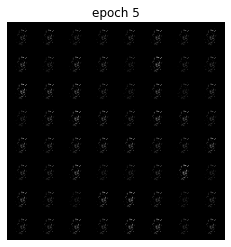

Epoch 5 of 100
Generator loss: 1.43247620, Discriminator loss: 1.14692420


118it [00:59,  1.98it/s]


Epoch 6 of 100
Generator loss: 1.10051098, Discriminator loss: 1.18246818


118it [00:54,  2.17it/s]


Epoch 7 of 100
Generator loss: 1.12826691, Discriminator loss: 1.12668745


118it [00:54,  2.16it/s]


Epoch 8 of 100
Generator loss: 1.70383623, Discriminator loss: 0.98178046


118it [00:53,  2.19it/s]


Epoch 9 of 100
Generator loss: 1.73019944, Discriminator loss: 0.99835147


118it [00:54,  2.16it/s]


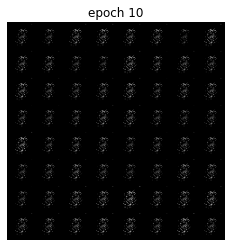

Epoch 10 of 100
Generator loss: 1.41053882, Discriminator loss: 1.09264854


118it [00:55,  2.14it/s]


Epoch 11 of 100
Generator loss: 1.38115048, Discriminator loss: 1.06074303


118it [00:53,  2.20it/s]


Epoch 12 of 100
Generator loss: 1.57834311, Discriminator loss: 0.96619304


118it [00:53,  2.22it/s]


Epoch 13 of 100
Generator loss: 1.64077485, Discriminator loss: 0.95112540


118it [00:52,  2.26it/s]


Epoch 14 of 100
Generator loss: 1.84404498, Discriminator loss: 0.98394696


118it [00:53,  2.22it/s]


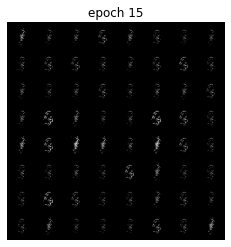

Epoch 15 of 100
Generator loss: 1.89144770, Discriminator loss: 0.88135621


118it [00:53,  2.19it/s]


Epoch 16 of 100
Generator loss: 1.88222158, Discriminator loss: 0.86860536


118it [00:54,  2.16it/s]


Epoch 17 of 100
Generator loss: 1.97246758, Discriminator loss: 0.89065591


118it [00:53,  2.20it/s]


Epoch 18 of 100
Generator loss: 1.74412411, Discriminator loss: 0.93541936


118it [00:53,  2.19it/s]


Epoch 19 of 100
Generator loss: 1.81497919, Discriminator loss: 0.87373299


118it [00:54,  2.18it/s]


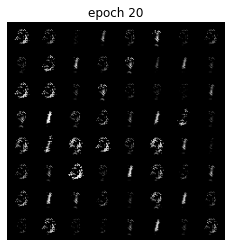

Epoch 20 of 100
Generator loss: 1.91269310, Discriminator loss: 0.85420660


118it [00:54,  2.15it/s]


Epoch 21 of 100
Generator loss: 1.85463373, Discriminator loss: 0.88261928


118it [00:56,  2.09it/s]


Epoch 22 of 100
Generator loss: 1.96594605, Discriminator loss: 0.87727548


118it [00:57,  2.04it/s]


Epoch 23 of 100
Generator loss: 1.84350415, Discriminator loss: 0.87159087


118it [00:54,  2.15it/s]


Epoch 24 of 100
Generator loss: 2.03411584, Discriminator loss: 0.84949068


118it [00:54,  2.16it/s]


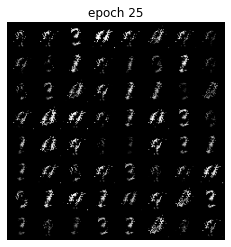

Epoch 25 of 100
Generator loss: 1.96940578, Discriminator loss: 0.82745155


118it [00:53,  2.19it/s]


Epoch 26 of 100
Generator loss: 1.88049533, Discriminator loss: 0.91506610


118it [00:54,  2.17it/s]


Epoch 27 of 100
Generator loss: 1.83003062, Discriminator loss: 0.88475787


118it [00:53,  2.22it/s]


Epoch 28 of 100
Generator loss: 1.78410328, Discriminator loss: 0.91981665


118it [00:52,  2.24it/s]


Epoch 29 of 100
Generator loss: 1.77035297, Discriminator loss: 0.89349523


118it [00:53,  2.19it/s]


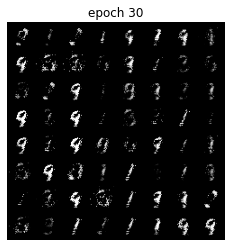

Epoch 30 of 100
Generator loss: 1.80664538, Discriminator loss: 0.86571397


118it [00:55,  2.14it/s]


Epoch 31 of 100
Generator loss: 1.90157472, Discriminator loss: 0.86277726


118it [00:55,  2.14it/s]


Epoch 32 of 100
Generator loss: 1.79338369, Discriminator loss: 0.86678095


118it [00:57,  2.07it/s]


Epoch 33 of 100
Generator loss: 1.81409585, Discriminator loss: 0.87361273


118it [00:54,  2.16it/s]


Epoch 34 of 100
Generator loss: 1.69612239, Discriminator loss: 0.90106469


118it [00:54,  2.15it/s]


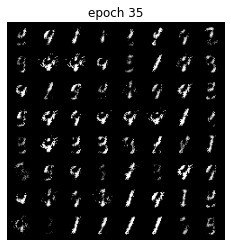

Epoch 35 of 100
Generator loss: 1.85738124, Discriminator loss: 0.87071875


118it [00:55,  2.12it/s]


Epoch 36 of 100
Generator loss: 1.84454092, Discriminator loss: 0.85727454


118it [00:55,  2.12it/s]


Epoch 37 of 100
Generator loss: 1.76484815, Discriminator loss: 0.85997200


118it [00:55,  2.12it/s]


Epoch 38 of 100
Generator loss: 1.83511527, Discriminator loss: 0.85242926


118it [00:56,  2.10it/s]


Epoch 39 of 100
Generator loss: 1.80666964, Discriminator loss: 0.86322153


118it [00:55,  2.13it/s]


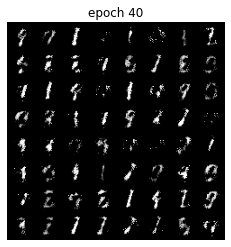

Epoch 40 of 100
Generator loss: 1.78857404, Discriminator loss: 0.85544860


118it [00:55,  2.12it/s]


Epoch 41 of 100
Generator loss: 1.73239500, Discriminator loss: 0.88746538


118it [00:55,  2.14it/s]


Epoch 42 of 100
Generator loss: 1.75522514, Discriminator loss: 0.88317540


118it [00:54,  2.15it/s]


Epoch 43 of 100
Generator loss: 1.72354509, Discriminator loss: 0.86722125


118it [00:55,  2.14it/s]


Epoch 44 of 100
Generator loss: 1.63013863, Discriminator loss: 0.92886374


118it [00:55,  2.12it/s]


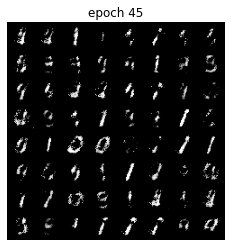

Epoch 45 of 100
Generator loss: 1.69266756, Discriminator loss: 0.90930846


118it [00:55,  2.12it/s]


Epoch 46 of 100
Generator loss: 1.64911913, Discriminator loss: 0.92567037


118it [00:55,  2.13it/s]


Epoch 47 of 100
Generator loss: 1.59691202, Discriminator loss: 0.93369338


118it [00:55,  2.14it/s]


Epoch 48 of 100
Generator loss: 1.57651697, Discriminator loss: 0.93763877


118it [00:55,  2.12it/s]


Epoch 49 of 100
Generator loss: 1.64849176, Discriminator loss: 0.93139916


118it [00:55,  2.11it/s]


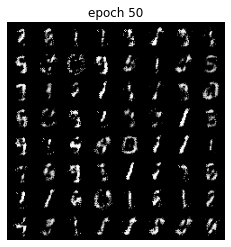

Epoch 50 of 100
Generator loss: 1.58018981, Discriminator loss: 0.93925844


118it [00:55,  2.13it/s]


Epoch 51 of 100
Generator loss: 1.47524781, Discriminator loss: 0.97952795


118it [00:55,  2.12it/s]


Epoch 52 of 100
Generator loss: 1.58386614, Discriminator loss: 0.97680562


118it [00:55,  2.14it/s]


Epoch 53 of 100
Generator loss: 1.62193393, Discriminator loss: 0.94477413


118it [00:55,  2.14it/s]


Epoch 54 of 100
Generator loss: 1.55062171, Discriminator loss: 0.96732549


118it [00:56,  2.10it/s]


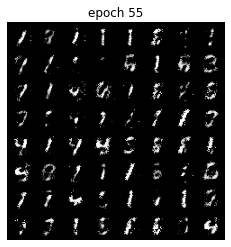

Epoch 55 of 100
Generator loss: 1.53155156, Discriminator loss: 0.95707898


118it [00:55,  2.14it/s]


Epoch 56 of 100
Generator loss: 1.63080280, Discriminator loss: 0.92355277


118it [00:55,  2.13it/s]


Epoch 57 of 100
Generator loss: 1.57300914, Discriminator loss: 0.92985744


118it [00:55,  2.14it/s]


Epoch 58 of 100
Generator loss: 1.52336638, Discriminator loss: 0.97320981


118it [00:54,  2.16it/s]


Epoch 59 of 100
Generator loss: 1.45727891, Discriminator loss: 0.99669591


118it [00:55,  2.12it/s]


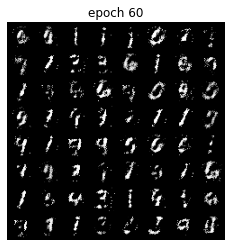

Epoch 60 of 100
Generator loss: 1.48148827, Discriminator loss: 0.97242563


118it [00:54,  2.15it/s]


Epoch 61 of 100
Generator loss: 1.47140668, Discriminator loss: 0.99351050


118it [00:54,  2.16it/s]


Epoch 62 of 100
Generator loss: 1.45030036, Discriminator loss: 1.01281982


118it [00:55,  2.13it/s]


Epoch 63 of 100
Generator loss: 1.43630514, Discriminator loss: 1.02154927


118it [00:54,  2.15it/s]


Epoch 64 of 100
Generator loss: 1.43654708, Discriminator loss: 1.05391561


118it [00:55,  2.15it/s]


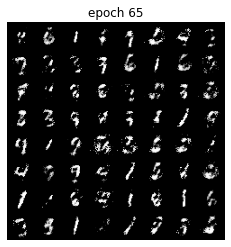

Epoch 65 of 100
Generator loss: 1.44721445, Discriminator loss: 1.02372102


118it [00:56,  2.08it/s]


Epoch 66 of 100
Generator loss: 1.34999284, Discriminator loss: 1.05786072


118it [00:54,  2.16it/s]


Epoch 67 of 100
Generator loss: 1.35799842, Discriminator loss: 1.06712835


118it [00:54,  2.15it/s]


Epoch 68 of 100
Generator loss: 1.37329765, Discriminator loss: 1.04137799


118it [00:55,  2.14it/s]


Epoch 69 of 100
Generator loss: 1.43780930, Discriminator loss: 1.01344521


118it [00:54,  2.15it/s]


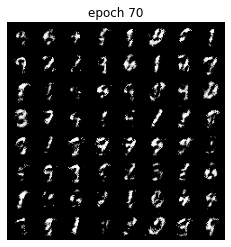

Epoch 70 of 100
Generator loss: 1.47303867, Discriminator loss: 1.00408800


118it [00:56,  2.10it/s]


Epoch 71 of 100
Generator loss: 1.50466588, Discriminator loss: 0.99804231


118it [00:55,  2.14it/s]


Epoch 72 of 100
Generator loss: 1.36855418, Discriminator loss: 1.04898305


118it [00:54,  2.18it/s]


Epoch 73 of 100
Generator loss: 1.40230627, Discriminator loss: 1.02857065


118it [00:54,  2.15it/s]


Epoch 74 of 100
Generator loss: 1.40508515, Discriminator loss: 1.01449670


118it [00:54,  2.16it/s]


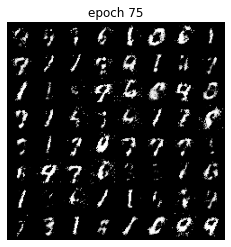

Epoch 75 of 100
Generator loss: 1.46385224, Discriminator loss: 1.00845416


118it [00:56,  2.10it/s]


Epoch 76 of 100
Generator loss: 1.40272454, Discriminator loss: 1.02472632


118it [00:54,  2.17it/s]


Epoch 77 of 100
Generator loss: 1.40559113, Discriminator loss: 1.02779881


118it [00:54,  2.16it/s]


Epoch 78 of 100
Generator loss: 1.37484539, Discriminator loss: 1.04209689


118it [00:54,  2.17it/s]


Epoch 79 of 100
Generator loss: 1.38581412, Discriminator loss: 1.02960963


118it [00:54,  2.15it/s]


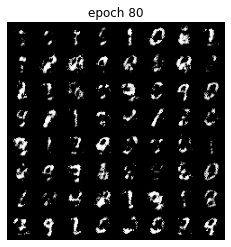

Epoch 80 of 100
Generator loss: 1.34752465, Discriminator loss: 1.06610386


118it [00:55,  2.11it/s]


Epoch 81 of 100
Generator loss: 1.32807575, Discriminator loss: 1.05399156


118it [00:54,  2.16it/s]


Epoch 82 of 100
Generator loss: 1.35957223, Discriminator loss: 1.03637194


118it [00:54,  2.16it/s]


Epoch 83 of 100
Generator loss: 1.43303644, Discriminator loss: 1.02771587


118it [00:54,  2.17it/s]


Epoch 84 of 100
Generator loss: 1.36937709, Discriminator loss: 1.05101059


118it [00:54,  2.16it/s]


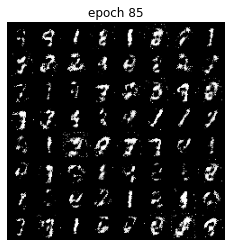

Epoch 85 of 100
Generator loss: 1.38331550, Discriminator loss: 1.04459600


118it [00:55,  2.14it/s]


Epoch 86 of 100
Generator loss: 1.39988441, Discriminator loss: 1.02719820


118it [00:54,  2.16it/s]


Epoch 87 of 100
Generator loss: 1.42727938, Discriminator loss: 1.01706968


118it [00:54,  2.16it/s]


Epoch 88 of 100
Generator loss: 1.30316211, Discriminator loss: 1.08305532


118it [00:53,  2.19it/s]


Epoch 89 of 100
Generator loss: 1.29739120, Discriminator loss: 1.08287426


118it [00:53,  2.19it/s]


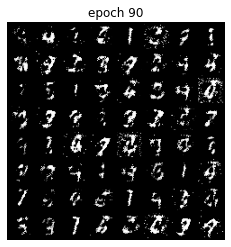

Epoch 90 of 100
Generator loss: 1.32781923, Discriminator loss: 1.07232314


118it [00:55,  2.13it/s]


Epoch 91 of 100
Generator loss: 1.40856079, Discriminator loss: 1.06581415


118it [00:54,  2.16it/s]


Epoch 92 of 100
Generator loss: 1.41609294, Discriminator loss: 1.05900325


118it [00:54,  2.15it/s]


Epoch 93 of 100
Generator loss: 1.34875032, Discriminator loss: 1.06893737


118it [00:54,  2.15it/s]


Epoch 94 of 100
Generator loss: 1.39966528, Discriminator loss: 1.03732067


118it [00:54,  2.16it/s]


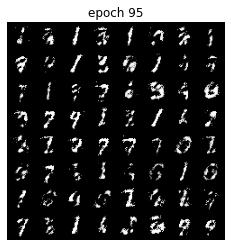

Epoch 95 of 100
Generator loss: 1.40273914, Discriminator loss: 1.02750017


118it [00:55,  2.14it/s]


Epoch 96 of 100
Generator loss: 1.48191748, Discriminator loss: 0.99811982


118it [00:55,  2.13it/s]


Epoch 97 of 100
Generator loss: 1.48323024, Discriminator loss: 1.01515220


118it [00:54,  2.18it/s]


Epoch 98 of 100
Generator loss: 1.39389665, Discriminator loss: 1.07057472


118it [00:54,  2.15it/s]


Epoch 99 of 100
Generator loss: 1.43934266, Discriminator loss: 1.02806043


118it [00:55,  2.13it/s]


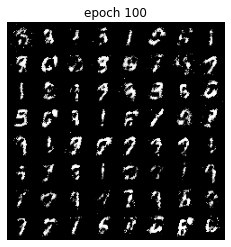

Epoch 100 of 100
Generator loss: 1.42747752, Discriminator loss: 1.02262529


In [ ]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 

        #get the input to device
        data[0].to(device)

        # optimize discriminator
        loss_d_total = 0.0
        for _ in range(num_steps_train_discriminator):
          generator_output = generator(create_noise(len(data[0]), nz)).detach() 
          optim_d.zero_grad()
          
          # .detach() to ensure not part of the graph

          #get the preds from discriminator on fake and true data
          gen_disc_output = discriminator(generator_output)
          true_data_output = discriminator(data[0])

          #optimize the loss
          
          disc_loss_fake, disc_loss_real  = discriminator_loss(gen_disc_output, true_data_output) #between fake and true images
          disc_loss_fake.backward()
          disc_loss_real.backward()
          optim_d.step()

          #increase counter
          loss_d_total += (disc_loss_fake+disc_loss_real).detach().cpu().numpy()
    
        # optimize generator
        optim_g.zero_grad()
        generator_output = generator(create_noise(len(data[0]), nz))
        gen_loss = generator_loss(generator_output)
        gen_loss.backward()
        optim_g.step()

        loss_g += gen_loss.detach().cpu().numpy()
        loss_d += loss_d_total / num_steps_train_discriminator
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [ ]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [ ]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

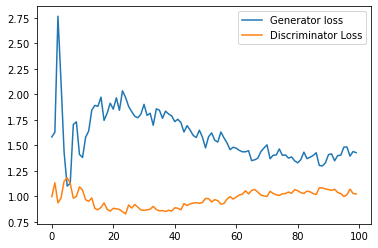

In [ ]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')